In [1]:
import os, sys
import warnings
warnings.filterwarnings("ignore")

import scanpy as sc
#sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)

import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

import gseapy as gp
from gseapy import barplot, dotplot

In [2]:
print(sc.__version__)
print(np.__version__)
print(pd.__version__)
print(sns.__version__)
print(mpl.__version__)
print(gp.__version__)


1.9.1
1.23.5
1.5.2
0.11.2
3.6.2
1.0.3


In [3]:
path = '/Users/busracagirici/Downloads/'
table_path = '/Users/busracagirici/Downloads/'
figure_path = '/Users/busracagirici/Downloads/'

adata = sc.read_h5ad(path+'GSE272840_ALO_viscRNAseq.h5ad')
adata

AnnData object with n_obs × n_vars = 21044 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [4]:
filtered =adata[adata.obs.high_quality=='True']
filtered

View of AnnData object with n_obs × n_vars = 20672 × 39895
    obs: 'species', 'run', 'ID', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'high_quality', 'viral_counts', 'cell_type'
    var: 'gene_id', 'gene_name', 'genome'

In [5]:
### Normalize RNA counts
filtered.layers['counts'] = filtered.X.copy()

sc.pp.normalize_total(filtered, target_sum=1e6)
sc.pp.log1p(filtered, base=2)
filtered.raw = filtered.copy()
filtered.layers['raw'] = filtered.X.copy()

In [6]:
### Fig. S8a

filtered.obs['bystanders'] = 'low (1-3)'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high >3'

filtered.obs['Infection status'] = filtered.obs.ID.str.contains('uninfected').astype(str)
filtered.obs['Infection status'] = filtered.obs['Infection status'].map({'True': 'Uninfected', 'False': 'SARS-CoV-2'})

filtered.obs['Treatment'] = filtered.obs.ID.str.contains('DMSO').astype(str)
filtered.obs['Treatment'] = filtered.obs['Treatment'].map({'True': 'DMSO', 'False': 'RMC-113'})

IDs = [x for x in filtered.obs.ID.unique() if '24' in x]
pd.DataFrame(filtered[filtered.obs.ID.isin(IDs)].obs.groupby(['Infection status', 'Treatment', 'bystanders']).size()).reset_index().pivot(columns='bystanders', values=0, index=['Infection status', 'Treatment']).fillna(0)



bystanders                  high >3  low (1-3)    zero
Infection status Treatment                            
SARS-CoV-2       DMSO         421.0     2649.0  5571.0
                 RMC-113      115.0     1363.0  6388.0
Uninfected       DMSO           0.0        0.0  1369.0
                 RMC-113        0.0        0.0  1833.0

In [7]:
ress = {}
for s in filtered.obs['ID'].cat.categories:
    print(s)
    #for ct in filtered.obs.cell_type.cat.categories:
    for ct in ['AT2-like cells']:
        if ct == 'NGFR-HOPX-CEACAM6+': continue
        adata_ct = filtered[filtered.obs.cell_type == ct].copy()
#        sc.pp.filter_genes(adata_ct, min_cells=3)
        sc.tl.rank_genes_groups(adata_ct, 'ID', method='wilcoxon', reference = s, key_added = "wilcoxon")
        ress[(ct, s)] = adata_ct.uns['wilcoxon']
        
        
markers = pd.DataFrame([])
for k,results in ress.items():
    ct = k[0]
    s = k[1]
    out = np.array([[0,0,0,0,0,0,0,0]])
    for group in results['names'].dtype.names:
        out = np.vstack((out, np.vstack((results['names'][group],
                                     results['scores'][group],
                                     results['pvals_adj'][group],
                                     results['pvals'][group],
                                     results['logfoldchanges'][group],
                                     np.array([group] * len(results['names'][group]),).astype('object'),
                                     np.array([s] * len(results['names'][group]),).astype('object'),
                                     np.array([ct] * len(results['names'][group]),).astype('object'),
                                    )).T
                        ))
    out = pd.DataFrame(out[1:], columns = ['Gene', 'scores', 'pval_adj', 'pval', 'lfc', 'Condition', 'reference', 'cell_type'])
    markers = pd.concat([markers, out], axis=0, join='outer')


markers['label'] = markers['Condition']+'_'+markers['reference']
labelmap = {'24h_infected_RMC-113_24h_infected_DMSO': '24h infected, RMC-113 vs DMSO',
           '24h_uninfected_RMC-113_24h_uninfected_DMSO': '24h uninfected, RMC-113 vs DMSO',
           '24h_infected_RMC-113_24h_uninfected_RMC-113': '24h RMC-113, infected vs uninfected',
           '24h_infected_DMSO_24h_uninfected_DMSO': '24h DMSO, infected vs uninfected',
           '4h_infected_RMC-113_4h_infected_DMSO': '4h infected, RMC-113 vs DMSO',
           '4h_uninfected_RMC-113_4h_uninfected_DMSO': '4h uninfected, RMC-113 vs DMSO',
           '4h_infected_RMC-113_4h_uninfected_RMC-113': '4h RMC-113, infected vs uninfected',
           '4h_infected_DMSO_4h_uninfected_DMSO': '4h DMSO, infected vs uninfected',
           
           }
markers['label'] = markers['label'].map(labelmap)
markers = markers[~markers['label'].isna()]
#markers

24h_infected_DMSO
24h_infected_RMC-113
24h_uninfected_DMSO
24h_uninfected_RMC-113
4h_infected_DMSO
4h_infected_RMC-113
4h_uninfected_DMSO
4h_uninfected_RMC-113


In [8]:
marker_genes = ["MTOR", ## "mTORC1", 
                "ULK1", "ATG13",
                "RB1CC1", ## "FIP200",
                "BECN1", 
                #"ATG14", 
#                   "PIK3C3", ## "PIK3C3/VPS34", 
                'ATG7', 'ATG8', 'ATG10', 'ATG12', 'ATG16L1', 
                'MAP1LC3B', 'SQSTM1', 
                'WDFY3','NBR1', 'TAX1BP1',
                "LAMP2", "TECPR1",
                "ATG14", "STX17", "VAMP8",
                "SNAP29", "RAB7A",  
                "PLEKHM1", "GABARAP",
                "VPS11", "VPS16", "VPS18",
                "VPS33A", "VPS33B", ## "Vps33", 
                   "VPS39", "VPS41",
                ]
genes = [x.upper() for x in marker_genes if x.upper() in filtered.var_names]
markers_genes = markers.reset_index().set_index('Gene').loc[genes, :].reset_index().set_index('index').fillna(0)
markers_tmp = markers_genes[markers_genes['cell_type'].isin([ct])]


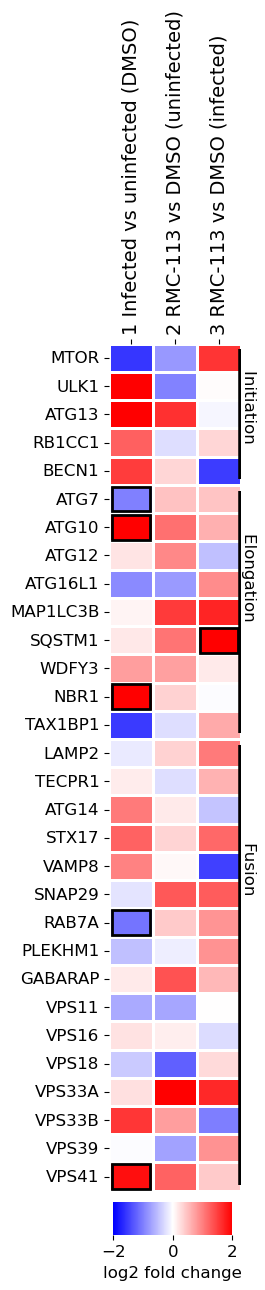

In [16]:
#### Figure S8b

fig, ax1 = plt.subplots(1,1,figsize=(1.7,11), gridspec_kw={'wspace':0.4})
cbar_ax = fig.add_axes([.15, .07, .7, .03])


#### 4h plots
ind = [4,7,6,]
tmp = markers_tmp.pivot_table(index='Gene', columns='label', values='lfc')
tmp = tmp[tmp.columns[ind]].loc[genes]
sns.heatmap(tmp, cmap='bwr', vmin=-2, vmax=2, ax=ax1, 
            linewidths=1,
            cbar=True, cbar_ax=cbar_ax, cbar_kws={'label': 'log2 fold change', 'orientation': 'horizontal'})
pval = markers_tmp.pivot_table(index='Gene', columns='label', values='pval')
pval = pval[pval.columns[ind]].loc[genes]
first = True
for i,col in enumerate(pval.columns):
    for j,gene in enumerate(pval.index):
        val = pval[col][gene]
        if val < 0.05:
            ax1.add_patch(
                mpl.patches.Rectangle(
                     (i+0.07, j+0.07),
                    0.87, 0.87,
                    edgecolor='black',
                    fill=False,
                    lw=2
                ) )
ax1.set_xticklabels(['1 Infected vs uninfected (DMSO)', '2 RMC-113 vs DMSO (uninfected)', '3 RMC-113 vs DMSO (infected)',],
                   fontsize=14, rotation=90)
ax1.xaxis.tick_top()


ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('')

ax1.vlines(x=3.01, ymin=0.2, ymax=4.8, linewidth=4, color='k')
ax1.vlines(x=3.01, ymin=5.2, ymax=13.8, linewidth=4, color='k')
ax1.vlines(x=3.01, ymin=14.2, ymax=29.8, linewidth=4, color='k')

title = 'Initiation                 Elongation                                          Fusion'
#ax1.set_title(title)
ax1.text(1, 0.97, title, rotation=270, horizontalalignment='left',
     verticalalignment='top', transform=ax1.transAxes)


fig.tight_layout()
#fig.savefig(figure_path+'heatmap_autophagy_genes_4h_linewidth1_3_new_updated.svg', format="svg")
#tmp.to_csv(f'{path}heatmap_4h.csv', sep='\t')
#pval.to_csv(f'{path}heatmap_4h_pval.csv', sep='\t')
plt.show()


In [17]:
def plot_gene_expression(filtered, ct, gene):
    from statannotations.Annotator import Annotator
    rcParams['font.size']=8

    adata_tmp = filtered[filtered.obs.cell_type == ct].copy()
    df = adata_tmp.obs[['ID', 'cell_type']]
    df[gene] = adata_tmp[:,gene].X.A
    df.index.name = 'cellID'
    df = df.reset_index()
    df['newID'] = [' '.join(x.split('_')[1:]) for x in df.ID]


    pairs = [
    ['uninfected RMC-113', 'uninfected DMSO'],
    ['infected RMC-113', 'infected DMSO'],
    ['infected DMSO', 'uninfected DMSO'],
#    ['infected RMC-113', 'uninfected DMSO'],
    ]
    order = ['uninfected DMSO', 
         'uninfected RMC-113', 
         'infected DMSO', 
         'infected RMC-113', 
        ]
    cmap = sns.color_palette('Set2', 4)
    hue_plot_params = {'data': df.dropna(),
                   'x' : 'newID', 
                   'y' : gene, 
                   'order': order,
                   'zorder' : 8,
                   'boxprops': {'edgecolor':'none'}, 
                   'medianprops' : {'color':'black', 'linewidth':0.5},
                   'capprops' : {'color':'none'},
                   'palette' : ['silver', 'whitesmoke', 'silver', 'whitesmoke',], 
                   'width' : 0.8, 
                   'showfliers': False}

    fig, ax = plt.subplots(figsize=[2.5, 3])
    sns.boxplot(ax=ax, **hue_plot_params).legend(bbox_to_anchor=(1, 1))

    empty_box=False
    if empty_box:
        for i,box in enumerate([p for p in ax.patches if not p.get_label()]): 
            color = box.get_facecolor()
            box.set_edgecolor(color)
            box.set_facecolor((0, 0, 0, 0))
            # iterate over whiskers and median lines
            for j in range(5*i,5*(i+1)):
                ax.lines[j].set_color(color)

            
    sns.stripplot(data = df.dropna(), 
              x = 'newID', y = gene, order=order, zorder=10,
             palette=cmap,  s=2, ax=ax, edgecolor='black', linewidth=0.3, dodge=True).legend('')


    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.new_plot(ax, **hue_plot_params)
    annotator.configure(test="Mann-Whitney", comparisons_correction="BH", 
                    text_format="full", verbose=False, show_test_name=False).apply_and_annotate()

    ax.legend(loc=(1.05, 0.5))
    ax.set_ylabel(f'{gene} (log2(CPM+1))', fontsize='medium')
    labels = [x.get_text() for x in ax.get_xticklabels()]
    ax.set_xticklabels([x.split()[1] for x in labels], rotation=45, fontsize='medium')
    ax.set_xlabel('Uninfected           Infected    ', fontsize='medium')
    ax.set_axisbelow(True)
    #ax.grid(True)


    #plt.savefig(f'{figure_path}{gene}_allpvals.svg')
    fig.tight_layout()
    #plt.savefig(f'{figure_path}{gene}_allpvals.png')
    plt.show()
    return(fig, ax)


In [18]:
filtered =filtered[(filtered.obs.high_quality=='True') & 
               #(adata.obs.cell_type.isin(['AT2-like cells'])) &
                (filtered.obs.ID.isin(['24h_infected_DMSO', '24h_infected_RMC-113', '24h_uninfected_DMSO', '24h_uninfected_RMC-113']))
               ]

ct = 'AT2-like cells'
adata_tmp = filtered[filtered.obs.cell_type == ct].copy()
df = adata_tmp.obs[['ID', 'cell_type']]

gene = ['ATG14', 'WDFY3']
df[gene] = adata_tmp[:,gene].X.A
df.index.name = 'cellID'
df = df.reset_index()
df['newID'] = [' '.join(x.split('_')[1:]) for x in df.ID]
#df.to_csv(f'{path}gene_expression_supp.csv', sep='\t')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


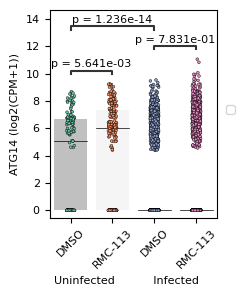

In [19]:
#### Fig S8c

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'ATG14')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


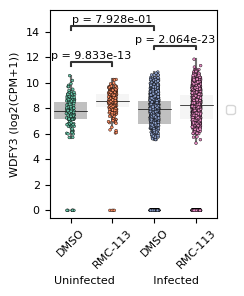

In [20]:
#### Fig S8d

fig, ax = plot_gene_expression(filtered, 'AT2-like cells', 'WDFY3')

In [7]:
def sample_and_compare(adata1, adata2, n_sample=0, n=100, log1p=2):    
    from random import sample
    if n_sample == 0: n_sample = min(adata1.shape[0], adata2.shape[0])

    var_names = [x for x in adata1.var_names if x in adata2.var_names]
    results = pd.DataFrame(np.zeros((n, len(var_names)), np.float64),
                           columns=var_names,
                          )

    for x in np.arange(n):
        # w/o replacement
        samplelist1 = sample(list(adata1.obs_names), n_sample)
        samplelist2 = sample(list(adata2.obs_names), n_sample)
        
        adata_1 = adata1[np.in1d(adata1.obs.index, samplelist1),:]
        adata_2 = adata2[np.in1d(adata2.obs.index, samplelist2),:]
        
        # Compute averages
        avg1 = adata_1.X.mean(axis=0)
        avg2 = adata_2.X.mean(axis=0)
        
        # Compute log2 fold changes
        if log1p is False: log2_fc = np.log2(avg1 + 1) - np.log2(avg2 + 1)
        elif log1p not in (True, 2): log2_fc = (avg1 - avg2) / np.log2(log1p)
        else: log2_fc = avg1 - avg2
        
        results.loc[x] = log2_fc

    return results


def boxplot_from_log2FC(log2FCs, linewidth=0.5, title='all_cell_types', xlim=3, cbar_label= 'log2 fold change \n(VHCs vs bystanders)\n24h_infected_DMSO', height=5, aspect = 0.5, vmin=-1.5, vmax = 1.5):
    fig, ax = plt.subplots(figsize=[height*aspect, height])
    cmap = sns.diverging_palette(245, 5, as_cmap=True)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    palette = [cmap(norm(x)) for x in np.clip(log2FCs.median(axis=0), vmin, vmax)]
    sns.boxplot(data=log2FCs, orient="h", ax=ax, palette=palette, linewidth=linewidth)
    ax.set_title(title)
    ax.set_xlim(xlim*-1, xlim)
    ax.tick_params(labelsize=12)
    #ax.set_xticks([str(x) for x in np.linspace(vmin,vmax,1)])
    for x in [-1, 0, 1]:
        ax.axvline(x, c='black', ls='-.', lw=0.5, zorder=0.5)
    
    ax_cb = fig.add_axes([0.15, 0.04, 0.65, 0.02])
    cbar = mpl.colorbar.ColorbarBase(ax_cb, norm=norm, cmap=cmap, orientation='horizontal')
    cbar.set_ticks(list(range(vmin, vmax+1, 1)))
    cbar.set_ticklabels([str(x) for x in list(range(vmin, vmax+1, 1))])
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label)

    return fig, ax


In [8]:
filtered.obs['bystanders'] = 'low'
filtered.obs.loc[filtered.obs.viral_counts==0, 'bystanders'] = 'zero'
filtered.obs.loc[filtered.obs.viral_counts>3, 'bystanders'] = 'high'


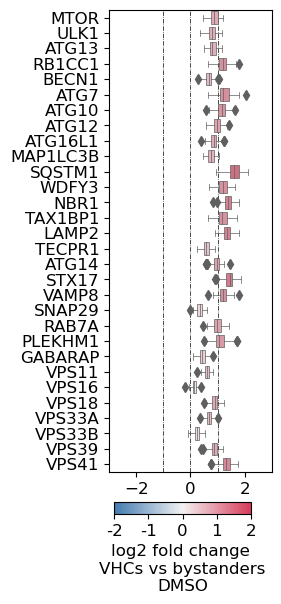

In [10]:
### Fig S8e
rcParams['font.size']=12

cond='bystanders'
samp='DMSO'
s = f'24h_infected_{samp}'
n_sample = 0

adata_s = filtered[filtered.obs.ID.str.startswith(s)].copy()
adata_s = adata_s[:, genes]
adata1 = adata_s[adata_s.obs.bystanders.isin(['high'])]
adata2 = adata_s[adata_s.obs.bystanders == 'zero']

#log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
log2fc_temp = pd.read_csv(f'{path}boxplot_DMSO.csv', sep='\t', index_col=0)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', bbox_inches='tight')
#log2fc_temp.to_csv(f'{path}boxplot_DMSO.csv', sep='\t')



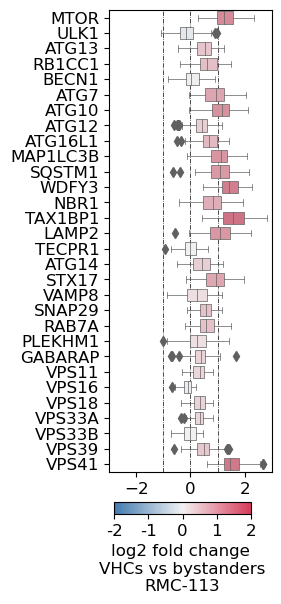

In [15]:
### Fig S8f

from matplotlib import rcParams
rcParams['font.size']=12

cond='bystanders'
samp='RMC-113'
s = f'24h_infected_{samp}'

adata_s = filtered[filtered.obs.ID.str.startswith(s)].copy()
adata_s = adata_s[:, genes]
adata1 = adata_s[adata_s.obs.bystanders.isin(['high'])]
adata2 = adata_s[adata_s.obs.bystanders == 'zero']

#log2fc_temp = sample_and_compare(adata1, adata2, n_sample=n_sample, n=100, log1p=2)
log2fc_temp = pd.read_csv(f'{path}boxplot_RMC113.csv', sep='\t', index_col=0)
fig, ax = boxplot_from_log2FC(log2fc_temp, xlim=3, vmin=-2, vmax=2,
                              title='',
                              height=6, aspect = 0.35, 
                              cbar_label= f'log2 fold change \nVHCs vs {cond}\n{samp}',
                             )
plt.show()
#fig.savefig(figure_path + f'boxplot_autophagy_genes_AT2_VHCs_vs_{cond}_{samp}_{n_sample}_new_allVHC.svg', bbox_inches='tight')
#log2fc_temp.to_csv(f'{path}boxplot_RMC113.csv', sep='\t')
